In [1]:
import ray

ray.init(dashboard_host="0.0.0.0")
print(ray.available_resources())

2024-08-15 12:50:04,189	WARNING services.py:2017 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.70gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-08-15 12:50:05,312	INFO worker.py:1772 -- Started a local Ray instance. View the dashboard at 172.25.4.192:8265 


{'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'node:172.25.4.192': 1.0, 'CPU': 32.0, 'memory': 9166091060.0, 'object_store_memory': 4583045529.0, 'GPU': 1.0}


In [3]:

from pymoo.optimize import minimize
import logging
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.core.variable import Choice, Real
from pymoo.algorithms.moo.nsga2 import RankAndCrowding
from pymoo.core.mixed import MixedVariableGA, MixedVariableMating, MixedVariableDuplicateElimination, \
    MixedVariableSampling
import numpy as np
from pymoo.core.problem import ElementwiseProblem, RayParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2


class MultiObjectiveMixedVariableProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        x1, x2, x3, x4, x5, x6, x7, x8 = X["1"], X["2"], X["3"], X["4"], X["5"], X["6"], X["7"], X["8"]

        out["F"] = [-x1, x2, x3, -x4, -x5, x6, x7, -x8]


real_vars = {
    "1": Real(bounds=(1 * 10 ** 1, 1 * 10 ** 8)),
    "2": Real(bounds=(1 * 10 ** -8, 1)),
    "3": Real(bounds=(1 * 10 ** 1, 1 * 10 ** 8)),
    "4": Real(bounds=(1 * 10 ** -8, 1)),
    "5": Real(bounds=(1 * 10 ** 1, 1 * 10 ** 8)),
    "6": Real(bounds=(1 * 10 ** -8, 1)),
    "7": Real(bounds=(1 * 10 ** 1, 1 * 10 ** 8)),
    "8": Real(bounds=(1 * 10 ** -8, 1)),
}

normalized_real_var_bounds = [np.array([var.lb, var.ub]) / np.abs(var.ub - var.lb) for var in real_vars.values()]
normalized_real_vars = {var_name: Real(bounds=bound) for var_name, bound in
                        zip(real_vars.keys(), normalized_real_var_bounds)}

step_1 = 1
step_2 = 1 * 10 ** -8
step_1 *= 1000
step_2 *= 10 ** 4
choice_vars = {
    "1": Choice(options=np.arange(1 * 10 ** 1, 1 * 10 ** 8 + step_1, step_1)),
    "2": Choice(options=np.arange(1 * 10 ** -8, 1 + step_2, step_2)),
    "3": Choice(options=np.arange(1 * 10 ** 1, 1 * 10 ** 8 + step_1, step_1)),
    "4": Choice(options=np.arange(1 * 10 ** -8, 1 + step_2, step_2)),
    "5": Choice(options=np.arange(1 * 10 ** 1, 1 * 10 ** 8 + step_1, step_1)),
    "6": Choice(options=np.arange(1 * 10 ** -8, 1 + step_2, step_2)),
    "7": Choice(options=np.arange(1 * 10 ** 1, 1 * 10 ** 8 + step_1, step_1)),
    "8": Choice(options=np.arange(1 * 10 ** -8, 1 + step_2, step_2)),
}
normalized_choice_var_bounds = [np.array([var.options[0], var.options[-1]]) / np.abs(var.options[-1] - var.options[0])
                                for var in
                                choice_vars.values()]
normalized_choice_vars = {var_name: Choice(options=np.arange(bound[0], bound[1] + step_2, step_2)) for var_name, bound
                          in zip(choice_vars.keys(), normalized_choice_var_bounds)}

combined_vars = {
    var_name: var for var_name, var in list(real_vars.items())[0:4] + list(choice_vars.items())[4:8]
}
combined_normalized_var_bounds = normalized_real_var_bounds[0:4] + normalized_choice_var_bounds[4:8]
combined_normalized_vars = {
    var_name: var for var_name, var in
    list(normalized_real_vars.items())[0:4] + list(normalized_choice_vars.items())[4:8]
}
runner = RayParallelization(job_resources={})
real_problem_un = MultiObjectiveMixedVariableProblem(elementwise_runner=runner, vars=real_vars, n_obj=8)
real_problem_n = MultiObjectiveMixedVariableProblem(elementwise_runner=runner, vars=normalized_real_vars, n_obj=8)
choice_problem_un = MultiObjectiveMixedVariableProblem(elementwise_runner=runner, vars=choice_vars, n_obj=8)
choice_problem_n = MultiObjectiveMixedVariableProblem(elementwise_runner=runner, vars=normalized_choice_vars, n_obj=8)
combined_problem_un = MultiObjectiveMixedVariableProblem(elementwise_runner=runner, vars=combined_vars, n_obj=8)
combined_problem_n = MultiObjectiveMixedVariableProblem(elementwise_runner=runner, vars=combined_normalized_vars,
                                                        n_obj=8)

mixed_smsemoa_algorithm = SMSEMOA(
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

mixed_ga_algorithm = MixedVariableGA(
    survival=RankAndCrowding(),
)

mixed_agemoea2_algorithm = AGEMOEA2(
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)


def run(input):
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    logger.info(f"input: {input['label']}")
    result = minimize(
        problem=input["problem"],
        algorithm=input["algorithm"],
        verbose=True,
        seed=1
    )
    output = {
        **input,
        "result": result,
    }
    return output



In [18]:
inputs = [
    {
        "label": {
            "problem": "real_problem_un",
            "algorithm": "mixed_agemoea2_algorithm"
        },
        "problem": real_problem_un,
        "algorithm": mixed_agemoea2_algorithm,
    },
    {
        "label": {
            "problem": "real_problem_n",
            "algorithm": "mixed_agemoea2_algorithm"
        },
        "problem": real_problem_n,
        "algorithm": mixed_agemoea2_algorithm,
    },
    {
        "label": {
            "problem": "choice_problem_un",
            "algorithm": "mixed_agemoea2_algorithm"
        },
        "problem": choice_problem_un,
        "algorithm": mixed_agemoea2_algorithm,
    },
    {
        "label": {
            "problem": "choice_problem_n",
            "algorithm": "mixed_agemoea2_algorithm"
        },
        "problem": choice_problem_n,
        "algorithm": mixed_agemoea2_algorithm,
    },
    {
        "label": {
            "problem": "combined_problem_un",
            "algorithm": "mixed_agemoea2_algorithm"
        },
        "problem": combined_problem_un,
        "algorithm": mixed_agemoea2_algorithm,
    },
    {
        "label": {
            "problem": "combined_problem_n",
            "algorithm": "mixed_agemoea2_algorithm"
        },
        "problem": combined_problem_n,
        "algorithm": mixed_agemoea2_algorithm,
    },
    {
        "label": {
            "problem": "real_problem_un",
            "algorithm": "mixed_smsemoa_algorithm"
        },
        "problem": real_problem_un,
        "algorithm": mixed_smsemoa_algorithm,
    },
    {
        "label": {
            "problem": "real_problem_n",
            "algorithm": "mixed_smsemoa_algorithm"
        },
        "problem": real_problem_n,
        "algorithm": mixed_smsemoa_algorithm,
    },
    {
        "label": {
            "problem": "choice_problem_un",
            "algorithm": "mixed_smsemoa_algorithm"
        },
        "problem": choice_problem_un,
        "algorithm": mixed_smsemoa_algorithm,
    },
    {
        "label": {
            "problem": "choice_problem_n",
            "algorithm": "mixed_smsemoa_algorithm"
        },
        "problem": choice_problem_n,
        "algorithm": mixed_smsemoa_algorithm,
    },
    {
        "label": {
            "problem": "combined_problem_un",
            "algorithm": "mixed_smsemoa_algorithm"
        },
        "problem": combined_problem_un,
        "algorithm": mixed_smsemoa_algorithm,
    },
    {
        "label": {
            "problem": "combined_problem_n",
            "algorithm": "mixed_smsemoa_algorithm"
        },
        "problem": combined_problem_n,
        "algorithm": mixed_smsemoa_algorithm,
    },
    {
        "label": {
            "problem": "real_problem_un",
            "algorithm": "mixed_ga_algorithm"
        },
        "problem": real_problem_un,
        "algorithm": mixed_ga_algorithm,
    },
    {
        "label": {
            "problem": "real_problem_n",
            "algorithm": "mixed_ga_algorithm"
        },
        "problem": real_problem_n,
        "algorithm": mixed_ga_algorithm,
    },
    {
        "label": {
            "problem": "choice_problem_un",
            "algorithm": "mixed_ga_algorithm"
        },
        "problem": choice_problem_un,
        "algorithm": mixed_ga_algorithm,
    },
    {
        "label": {
            "problem": "choice_problem_n",
            "algorithm": "mixed_ga_algorithm"
        },
        "problem": choice_problem_n,
        "algorithm": mixed_ga_algorithm,
    },
    {
        "label": {
            "problem": "combined_problem_un",
            "algorithm": "mixed_ga_algorithm"
        },
        "problem": combined_problem_un,
        "algorithm": mixed_ga_algorithm,
    },
    {
        "label": {
            "problem": "combined_problem_n",
            "algorithm": "mixed_ga_algorithm"
        },
        "problem": combined_problem_n,
        "algorithm": mixed_ga_algorithm,
    },
]

tasks = [ray.remote(run).remote(input) for input in inputs]
results = ray.get(tasks)

In [19]:
import copy

copied_results = copy.deepcopy(results)

In [20]:
copied_results

[{'label': {'problem': 'real_problem_un',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.MultiObjectiveMixedVariableProblem at 0x7f2f68f91ff0>,
  'algorithm': <pymoo.algorithms.moo.age2.AGEMOEA2 at 0x7f2f68f915d0>,
  'result': <pymoo.core.result.Result at 0x7f2f68f90460>},
 {'label': {'problem': 'real_problem_n',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.MultiObjectiveMixedVariableProblem at 0x7f2f4238bac0>,
  'algorithm': <pymoo.algorithms.moo.age2.AGEMOEA2 at 0x7f2f68d3f9a0>,
  'result': <pymoo.core.result.Result at 0x7f2f68d3f3d0>},
 {'label': {'problem': 'choice_problem_un',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.MultiObjectiveMixedVariableProblem at 0x7f2f68d3f460>,
  'algorithm': <pymoo.algorithms.moo.age2.AGEMOEA2 at 0x7f2f68fc1a50>,
  'result': <pymoo.core.result.Result at 0x7f2f68fc15d0>},
 {'label': {'problem': 'choice_problem_n',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.Mul

In [21]:
import numpy as np
from pymoo.visualization.pcp import PCP
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.asf import ASF


def get_decision(res):
    decomp = ASF()
    approx_ideal = res.F.min(axis=0)
    approx_nadir = res.F.max(axis=0)

    denominator = approx_nadir - approx_ideal
    denominator[denominator == 0] += np.finfo(denominator.dtype).eps
    nF = (res.F - approx_ideal) / denominator
    weights = np.array([0.5] * 8, dtype=np.float64)
    weights[weights == 0] += np.finfo(weights.dtype).eps
    normalized_weights = weights / weights.sum()
    i = decomp.do(nF, 1 / normalized_weights).argmin()

    return i


for copied_result in copied_results:
    copied_result["decision"] = get_decision(copied_result["result"])

In [22]:
copied_results

[{'label': {'problem': 'real_problem_un',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.MultiObjectiveMixedVariableProblem at 0x7f2f68f91ff0>,
  'algorithm': <pymoo.algorithms.moo.age2.AGEMOEA2 at 0x7f2f68f915d0>,
  'result': <pymoo.core.result.Result at 0x7f2f68f90460>,
  'decision': 41},
 {'label': {'problem': 'real_problem_n',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.MultiObjectiveMixedVariableProblem at 0x7f2f4238bac0>,
  'algorithm': <pymoo.algorithms.moo.age2.AGEMOEA2 at 0x7f2f68d3f9a0>,
  'result': <pymoo.core.result.Result at 0x7f2f68d3f3d0>,
  'decision': 14},
 {'label': {'problem': 'choice_problem_un',
   'algorithm': 'mixed_agemoea2_algorithm'},
  'problem': <__main__.MultiObjectiveMixedVariableProblem at 0x7f2f68d3f460>,
  'algorithm': <pymoo.algorithms.moo.age2.AGEMOEA2 at 0x7f2f68fc1a50>,
  'result': <pymoo.core.result.Result at 0x7f2f68fc15d0>,
  'decision': 0},
 {'label': {'problem': 'choice_problem_n',
   'algorithm': 'm

                                                                                                                                                                                 x  \
41  {'1': 100000000.0, '2': 1e-08, '3': 10.00000000004599, '4': 0.9999999999999996, '5': 100000000.0, '6': 1.0000005681164848e-08, '7': 10.00000000000456, '8': 0.999999999999999}   

                                                                                                                                                                 f  \
41  {1: 100000000.0, 2: 1e-08, 3: 10.00000000004599, 4: 0.9999999999999996, 5: 100000000.0, 6: 1.0000005681164848e-08, 7: 10.00000000000456, 8: 0.999999999999999}   

    decision  
41      True  
                                                                                                                                                                                                                           x  \
14  {'1': 1.0000001000000098, '2': 1.00000010898

/usr/local/lib/python3.10/dist-packages/pymoo/core/plot.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=self.figsize)


                                                                                                                                                                               x  \
0  {'1': 98818700.69773616, '2': 0.0010256651083911938, '3': 7311125.724502803, '4': 0.9034976502755372, '5': 80567010, '6': 0.21410001, '7': 24062010, '8': 0.9992000100000001}   

                                                                                                                                                                   f  \
0  {1: 98818700.69773616, 2: 0.0010256651083911938, 3: 7311125.724502803, 4: 0.9034976502755372, 5: 80567010.0, 6: 0.21410001, 7: 24062010.0, 8: 0.9992000100000001}   

   decision  
0      True  
                                                                                                                                                                                   x  \
70  {'1': 0.9664039636476079, '2': 0.08029092324059307, '3': 0.05279528877946649, '4': 0.9

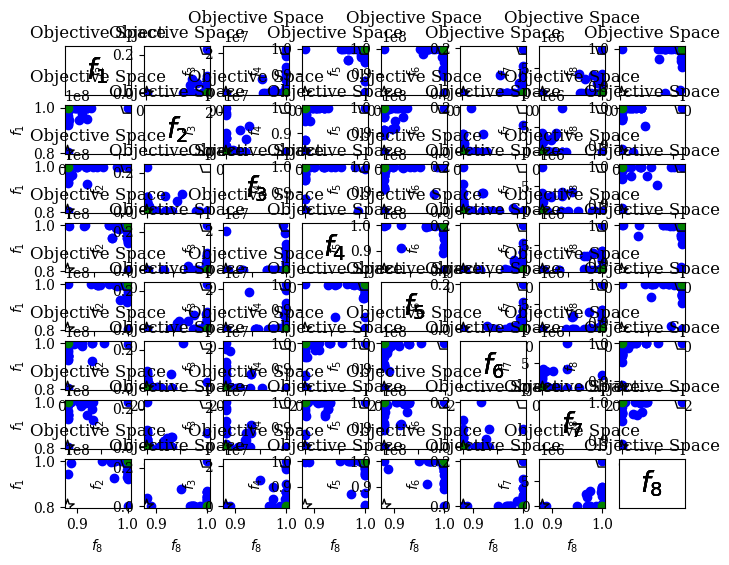

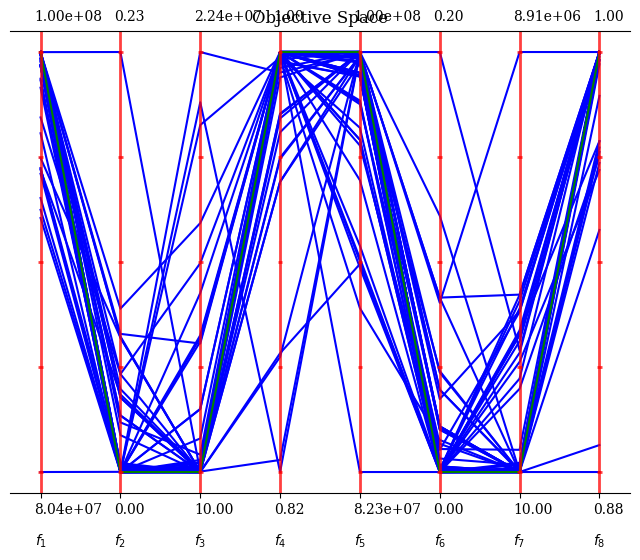

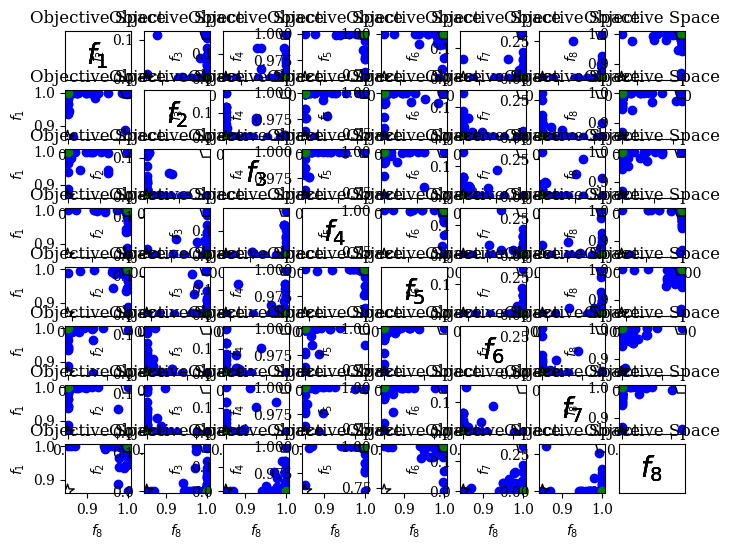

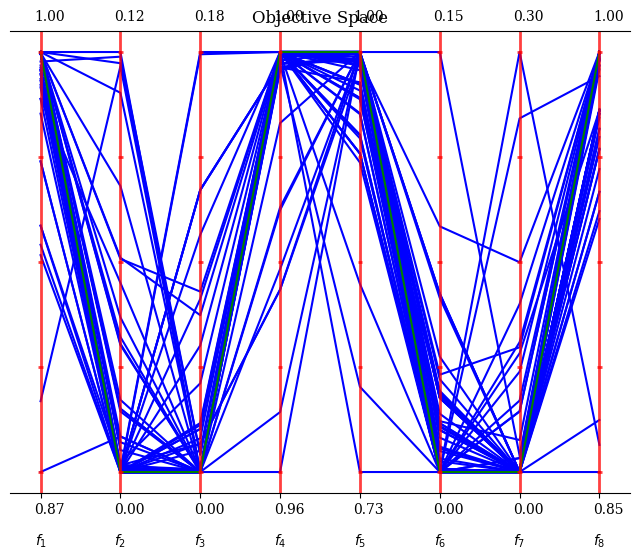

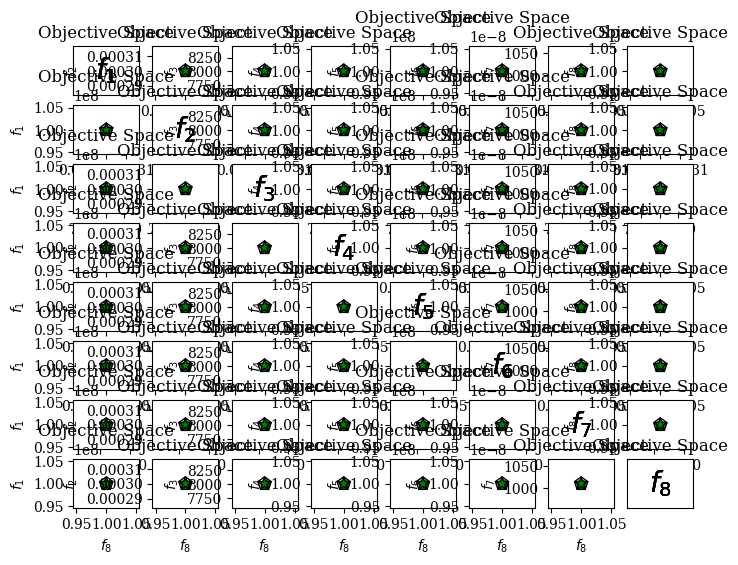

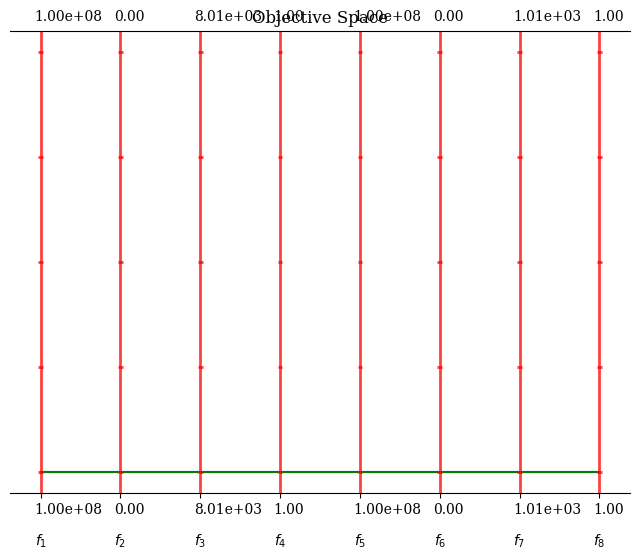

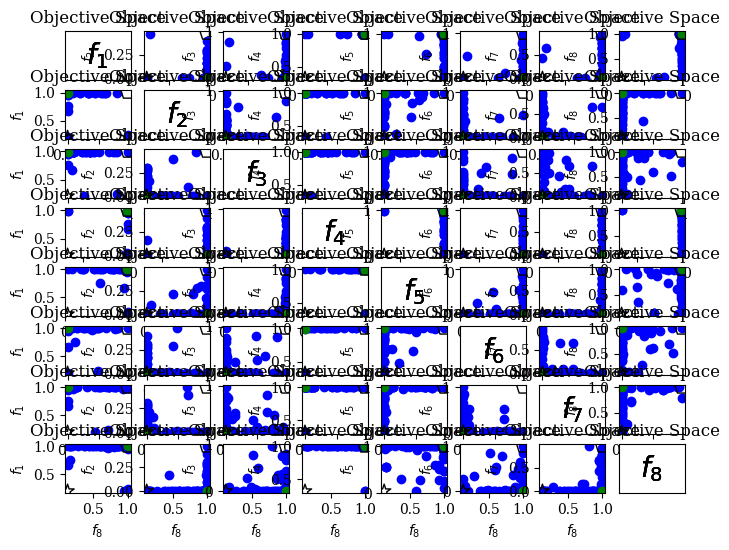

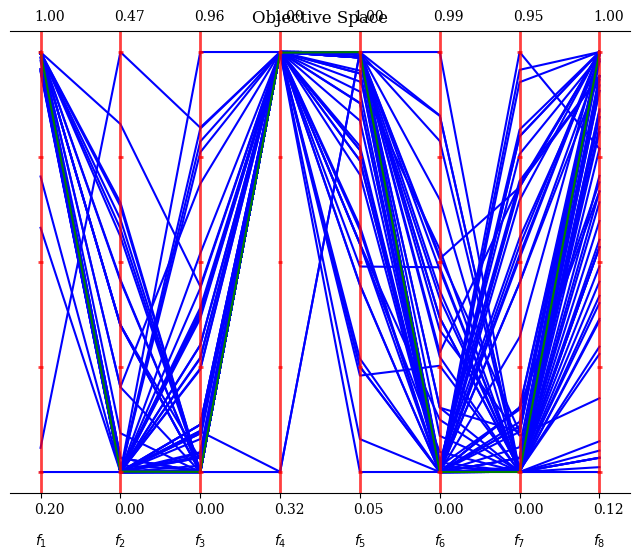

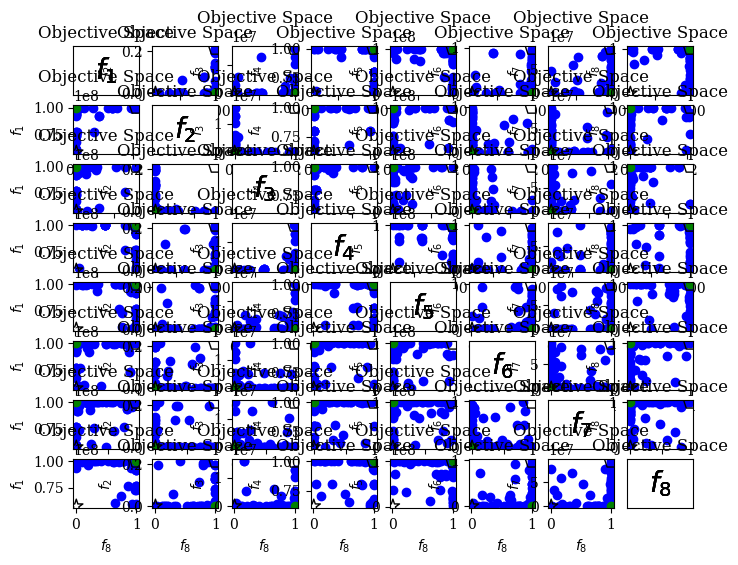

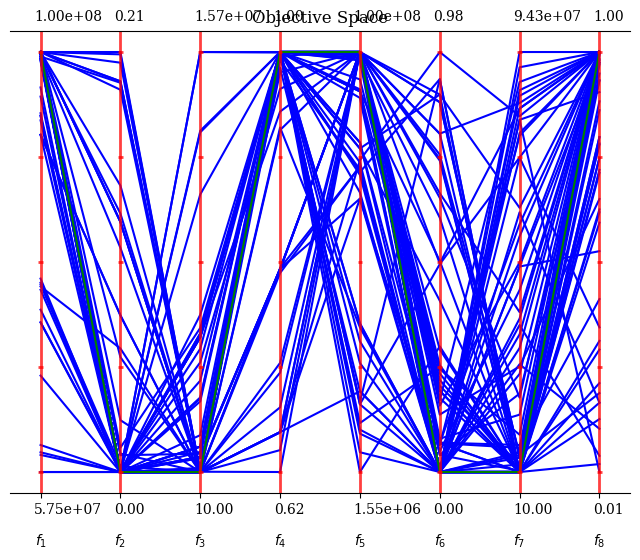

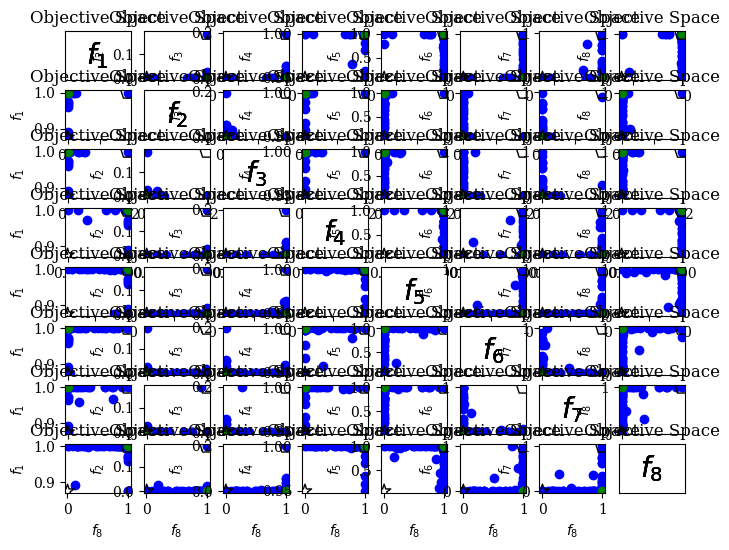

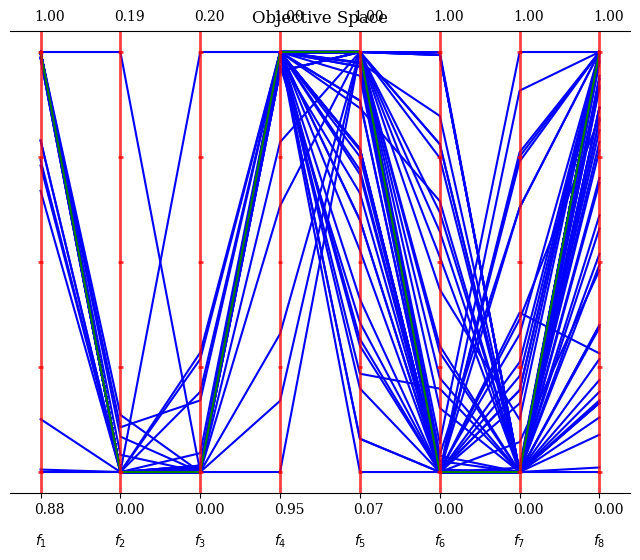

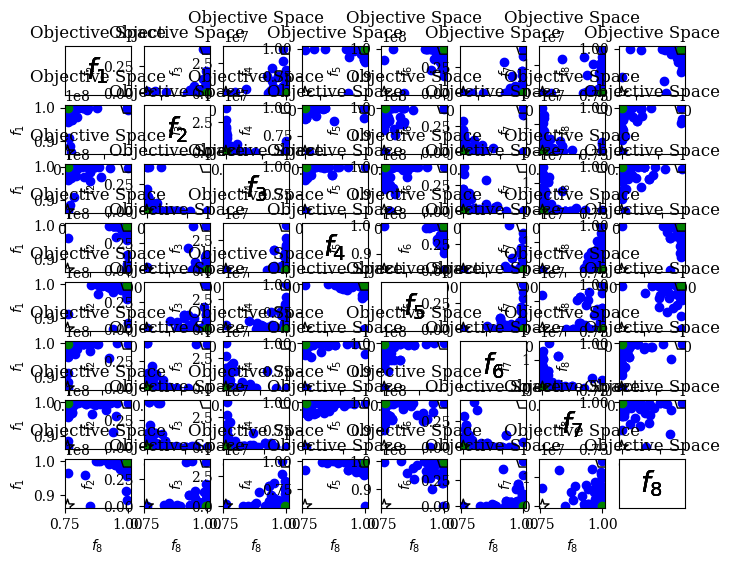

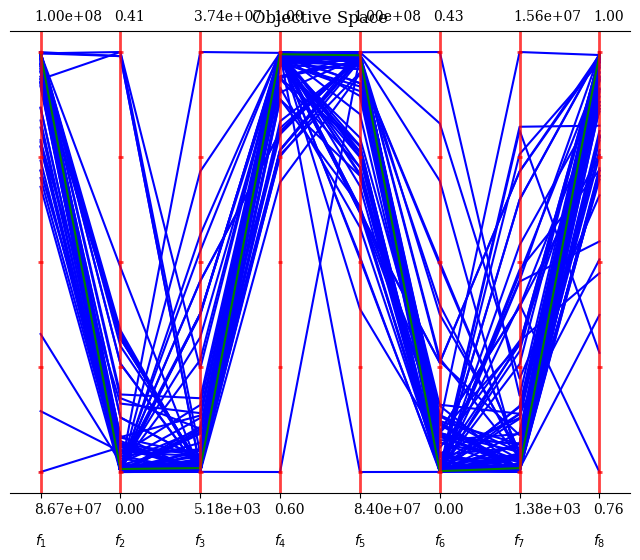

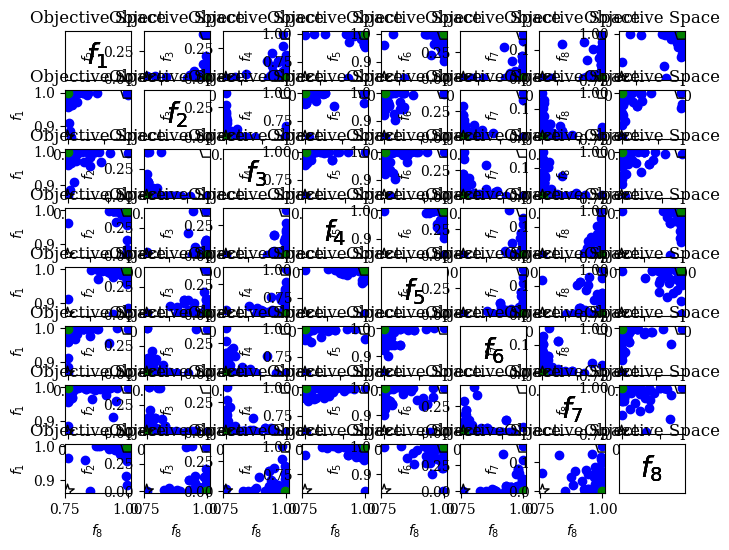

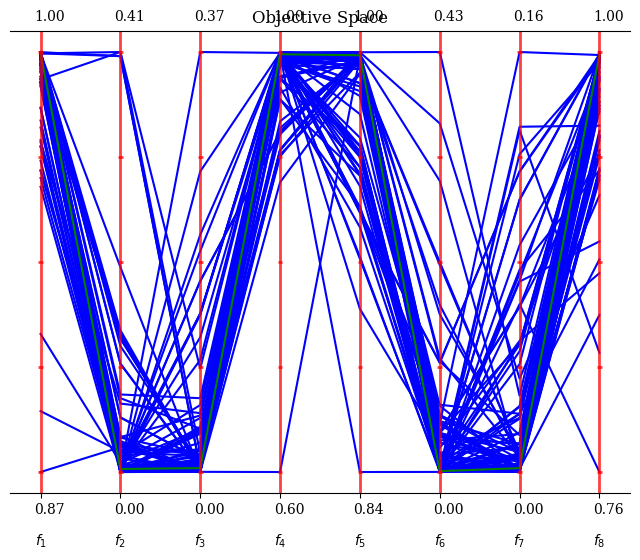

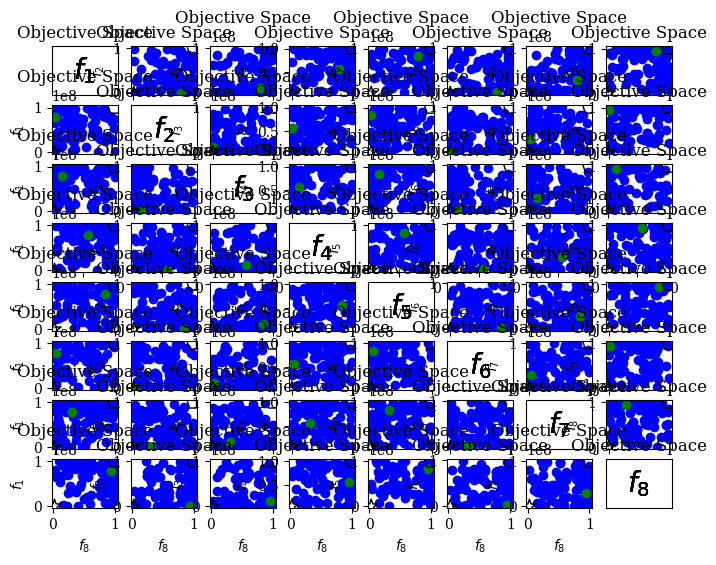

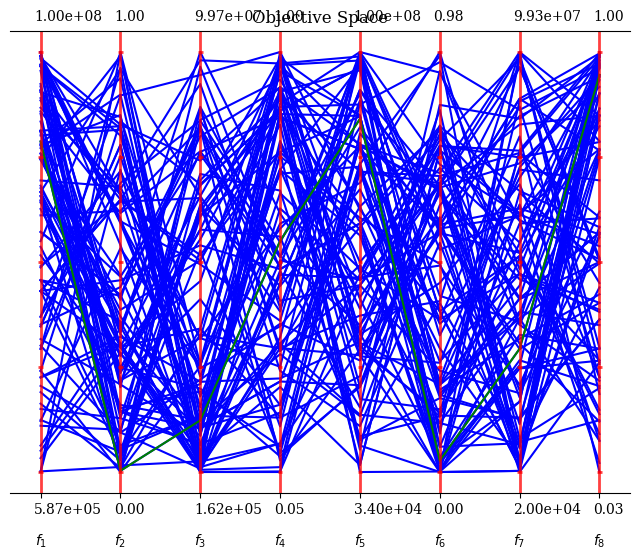

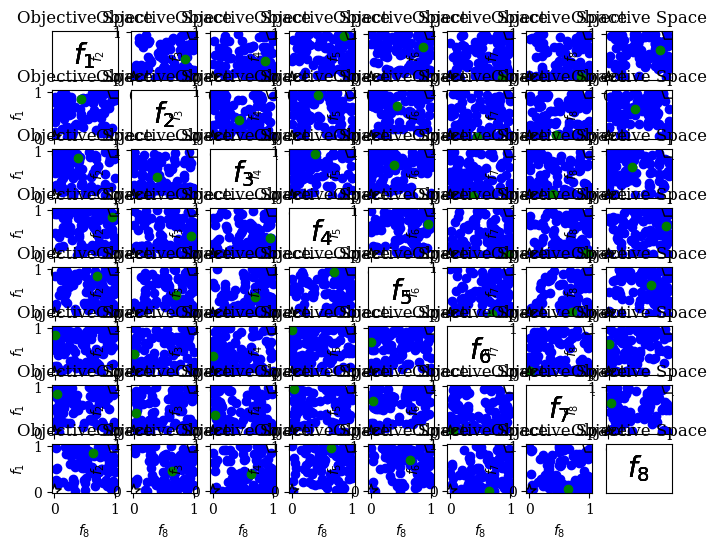

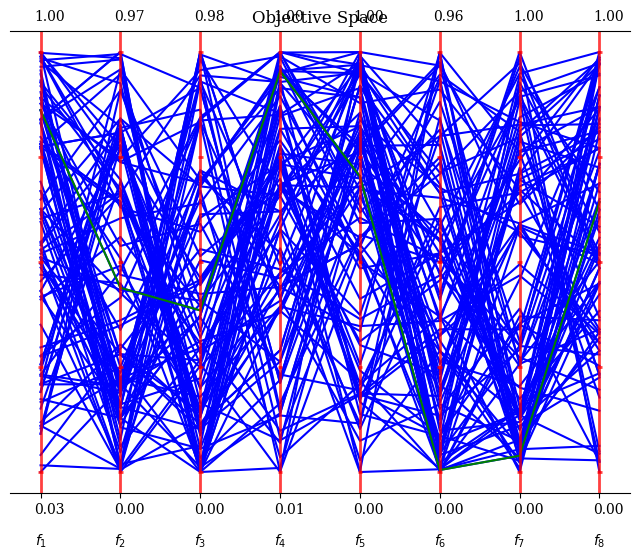

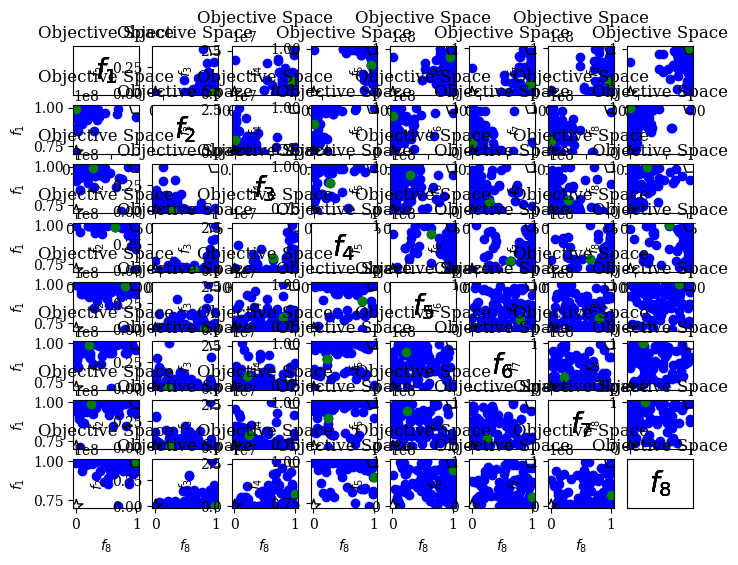

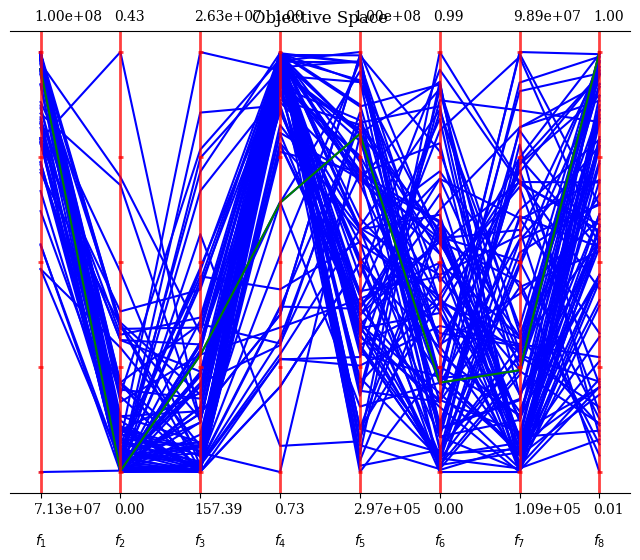

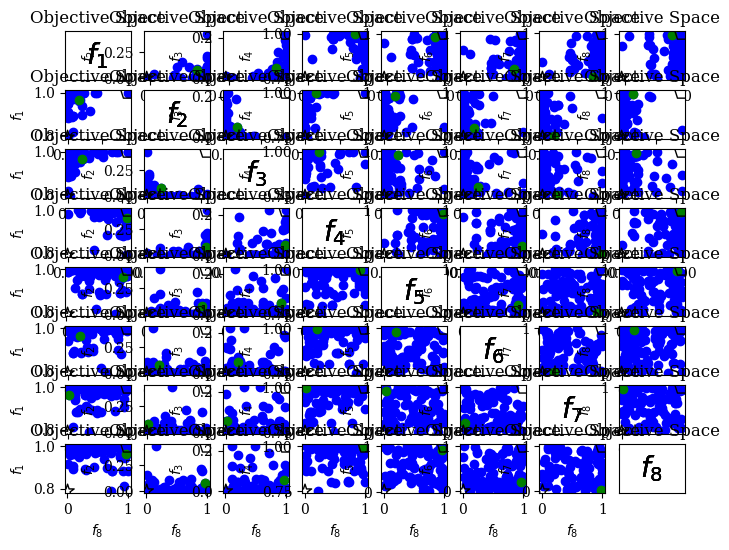

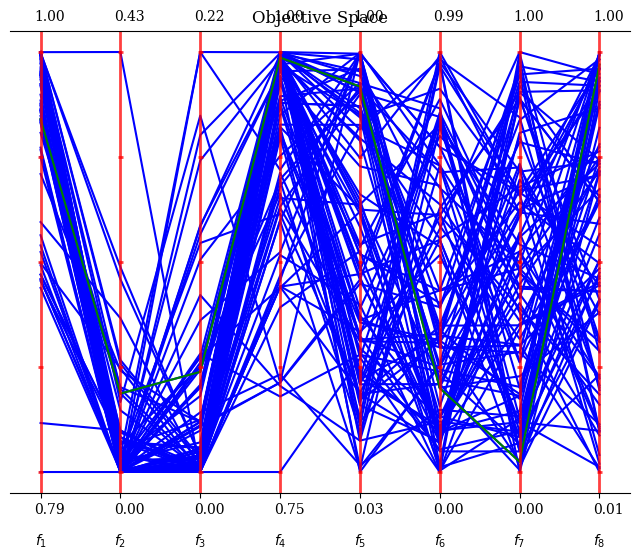

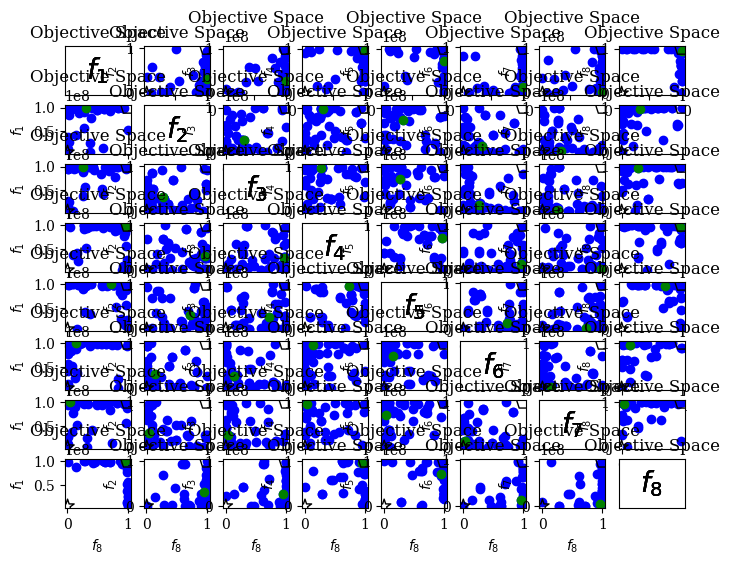

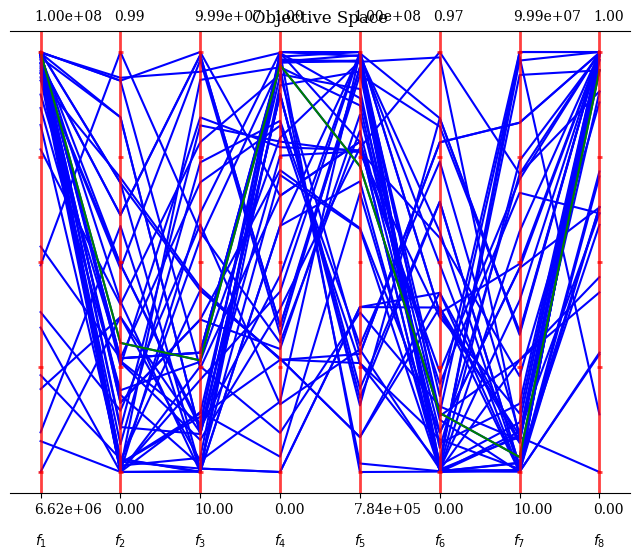

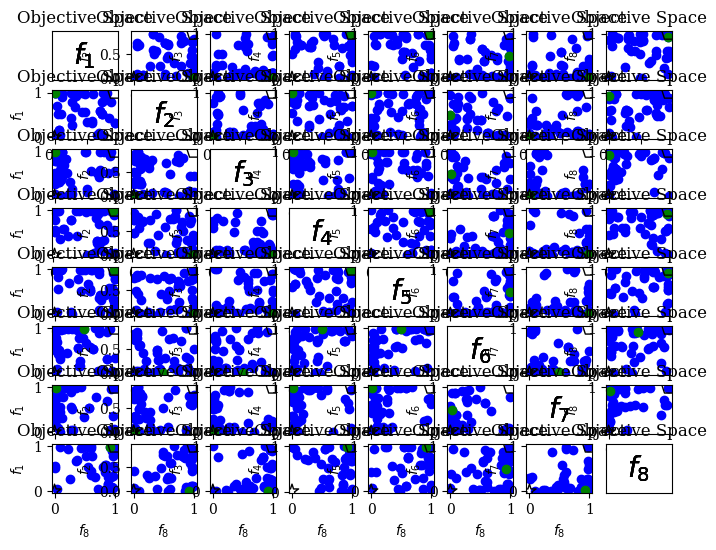

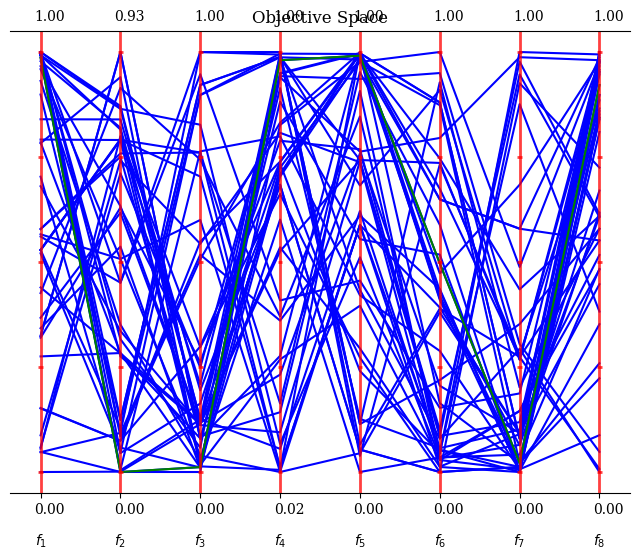

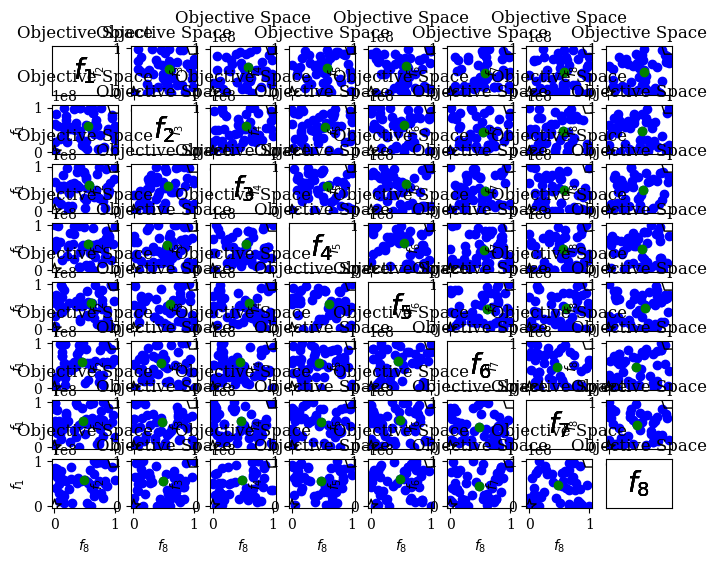

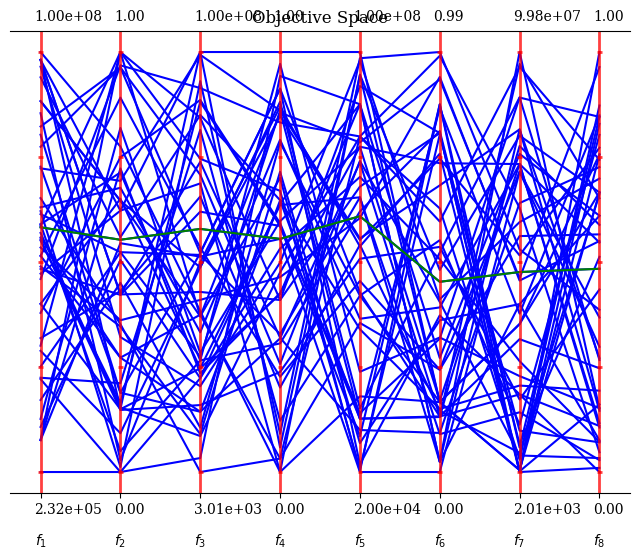

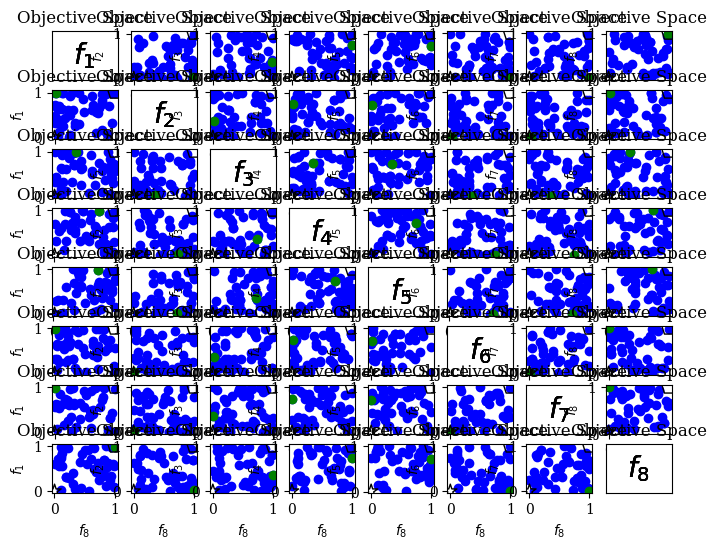

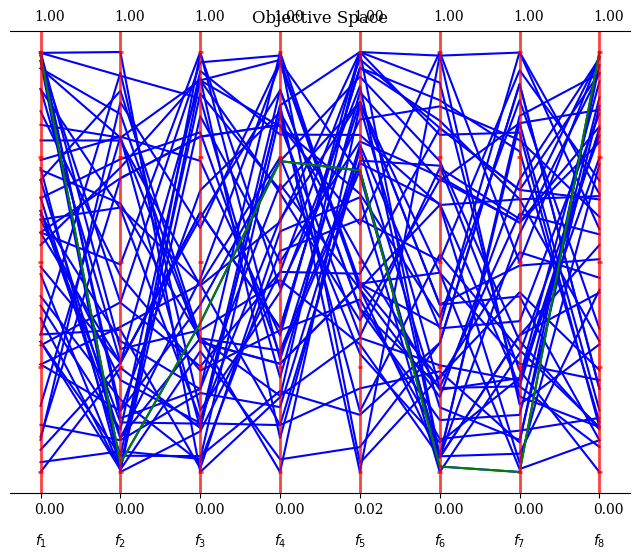

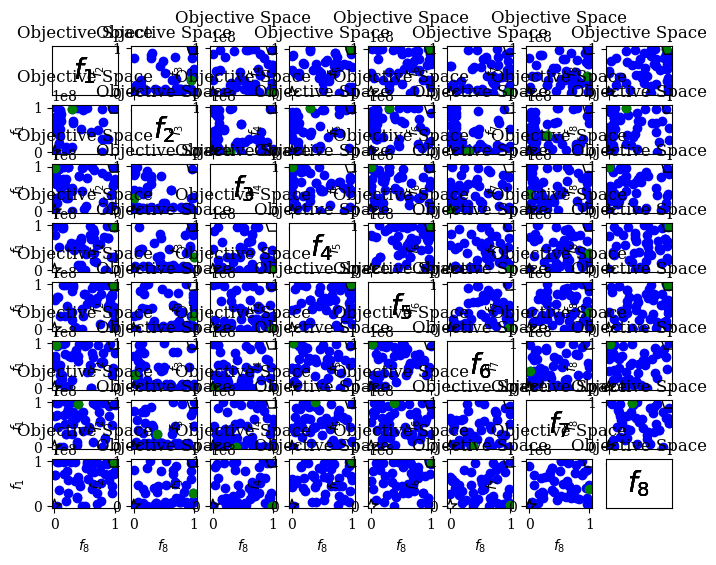

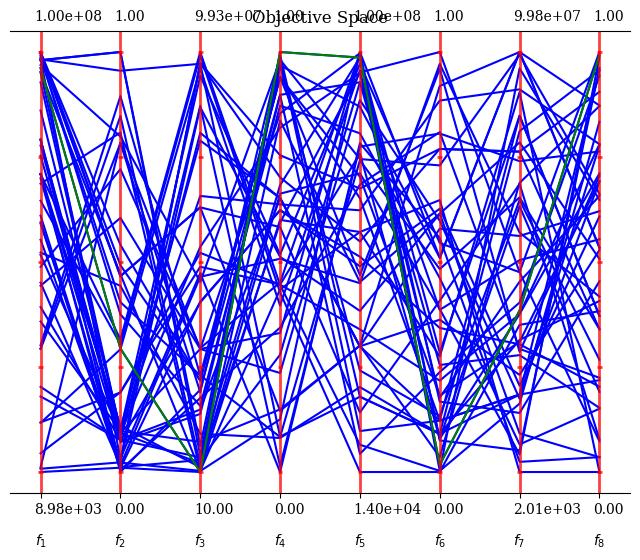

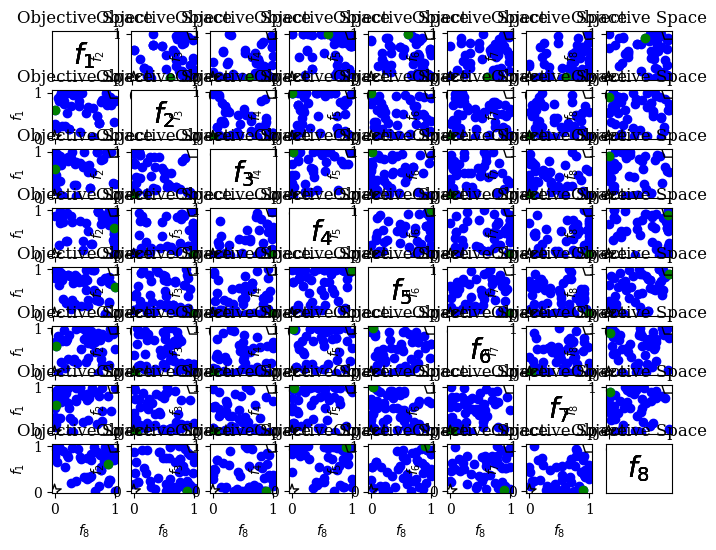

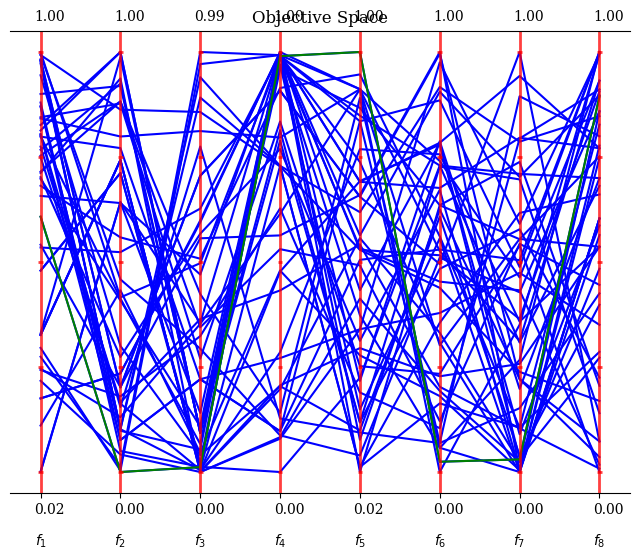

In [23]:
import pandas as pd
%matplotlib inline
pd.set_option('display.max_colwidth', None)


def get_plot(result):
    res = result["result"]
    i = result["decision"]
    res.F[:, [0, 3, 4, 7]] *= -1
    approx_ideal = res.F.min(axis=0)
    approx_nadir = res.F.max(axis=0)
    plot_0 = Scatter()
    plot_0.add(res.F, color="blue")
    plot_0.add(res.F[i], color="green")
    plot_0.add(approx_ideal, facecolors='none', edgecolors='black', marker="*", s=100, label="Ideal Point (Approx)")
    plot_0.add(approx_nadir, facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
    plot_0.title = "Objective Space"
    plot_0.show()

    plot_1 = PCP()
    plot_1.add(res.F, color="blue")
    plot_1.add(res.F[i], color="green")
    plot_1.title = "Objective Space"
    plot_1.show()

    plot_2_maps = []
    for index, (x, f) in enumerate(zip(res.X, res.F)):
        x_values = {}
        for variable_id, value in x.items():
            x_values[variable_id] = value

        f_values = {}
        for objective_index, value in enumerate(f):
            f_values[objective_index + 1] = value

        plot_2_map = {
            "x": x_values,
            "f": f_values,
            "decision": index == i,
        }
        plot_2_maps.append(plot_2_map)

    plot_2_df = pd.DataFrame(plot_2_maps)
    print(plot_2_df[plot_2_df["decision"] == True])

    return [plot_0, plot_1, plot_2_df]


for copied_result in copied_results:
    copied_result["plots"] = get_plot(copied_result)

In [24]:
from pprint import pp
import rexmex


def evaluate(result):
    res = result["result"]
    plot = result["plots"][2]
    problem = result["problem"]

    d = plot[plot["decision"] == True]
    d_f = [d["f"].values[0][i] for i in range(1, 9)]
    if result["label"]["problem"].startswith("real"):
        bounds = [[var.lb, var.ub] for var in problem.vars.values()]
    elif result["label"]["problem"].startswith("choice"):
        bounds = [[var.options[0], var.options[-1]] for var in problem.vars.values()]
    elif result["label"]["problem"].startswith("combined"):
        bounds = [[var.lb, var.ub] for var in list(problem.vars.values())[0:4]] + [[var.options[0], var.options[-1]]
                                                                                   for var in
                                                                                   list(problem.vars.values())[4:8]]
    else:
        raise Exception("Unknown problem")
    
    pf = [bounds[0][-1], bounds[1][0], bounds[2][0], bounds[3][-1], bounds[4][-1], bounds[5][0], bounds[6][0],
          bounds[7][-1]]
    evaluation = {}
    evaluation["smape f"] = rexmex.metrics.symmetric_mean_absolute_percentage_error([pf] * res.F.shape[0], res.F)
    evaluation["mae f"] = rexmex.metrics.mean_absolute_error([pf] * res.F.shape[0], res.F)
    r_mae_f = []
    for f in res.F:
        f_err = []
        for i in range(8):
            bound = np.abs(bounds[i][1] - bounds[i][0])
            dist = np.abs(pf[i] - f[i])
            err = dist / bound
            f_err.append(err)
        r_mae_f.append(np.average(f_err))
    evaluation["bound relative mae f"] = np.average(r_mae_f)
    evaluation["smape d_f"] = rexmex.metrics.symmetric_mean_absolute_percentage_error(np.array(pf), np.array(d_f))
    evaluation["mae d_f"] = rexmex.metrics.mean_absolute_error(pf, d_f)
    d_f_err = []
    for i in range(8):
        bound = np.abs(bounds[i][1] - bounds[i][0])
        dist = np.abs(pf[i] - d_f[i])
        err = dist / bound
        d_f_err.append(err)
    evaluation["bound relative mae d_f"] = np.average(d_f_err)

    return evaluation


evaluations = []
for result in copied_results:
    result["evaluation"] = evaluate(result)

    evaluation = {
        "label": str(result["label"]),
        **result["evaluation"],
    }
    evaluations.append(evaluation)

df_evaluation = pd.DataFrame(evaluations)


min
{'smape f': {'value': 42.48697231542971,
             'label': {'problem': 'combined_problem_n',
                       'algorithm': 'mixed_agemoea2_algorithm'}},
 'mae f': {'value': 0.010396129661064698,
           'label': {'problem': 'real_problem_n',
                     'algorithm': 'mixed_agemoea2_algorithm'}},
 'bound relative mae f': {'value': 6.999999999998476e-05,
                          'label': {'problem': 'choice_problem_un',
                                    'algorithm': 'mixed_agemoea2_algorithm'}},
 'smape d_f': {'value': 1.7206956223465228e-06,
               'label': {'problem': 'real_problem_n',
                         'algorithm': 'mixed_agemoea2_algorithm'}},
 'mae d_f': {'value': 6.698763398966454e-16,
             'label': {'problem': 'real_problem_n',
                       'algorithm': 'mixed_agemoea2_algorithm'}},
 'bound relative mae d_f': {'value': 6.698763398966454e-16,
                            'label': {'problem': 'real_problem_n',
            

In [25]:
df_evaluation

label  \
0       {'problem': 'real_problem_un', 'algorithm': 'mixed_agemoea2_algorithm'}   
1        {'problem': 'real_problem_n', 'algorithm': 'mixed_agemoea2_algorithm'}   
2     {'problem': 'choice_problem_un', 'algorithm': 'mixed_agemoea2_algorithm'}   
3      {'problem': 'choice_problem_n', 'algorithm': 'mixed_agemoea2_algorithm'}   
4   {'problem': 'combined_problem_un', 'algorithm': 'mixed_agemoea2_algorithm'}   
5    {'problem': 'combined_problem_n', 'algorithm': 'mixed_agemoea2_algorithm'}   
6        {'problem': 'real_problem_un', 'algorithm': 'mixed_smsemoa_algorithm'}   
7         {'problem': 'real_problem_n', 'algorithm': 'mixed_smsemoa_algorithm'}   
8      {'problem': 'choice_problem_un', 'algorithm': 'mixed_smsemoa_algorithm'}   
9       {'problem': 'choice_problem_n', 'algorithm': 'mixed_smsemoa_algorithm'}   
10   {'problem': 'combined_problem_un', 'algorithm': 'mixed_smsemoa_algorithm'}   
11    {'problem': 'combined_problem_n', 'algorithm': 'mixed_smsemoa_algorithm'}   
12            {'problem': 'real_problem_un', 'algorithm': 'mixed_ga_algorithm'}   
13             {'problem': 'real_problem_n', 'algorithm': 'mixed_ga_algorithm'}   
14          {'problem': 'choice_problem_un', 'algorithm': 'mixed_ga_algorithm'}   
15           {'problem': 'choice_problem_n', 'algorithm': 'mixed_ga_algorithm'}   
16        {'problem': 'combined_problem_un', 'algorithm': 'mixed_ga_algorithm'}   
17         {'problem': 'combined_problem_n', 'algorithm': 'mixed_ga_algorithm'}   

       smape f         mae f  bound relative mae f   smape d_f       mae d_f  \
0    61.270190  4.939706e+05              0.009349    0.000007  6.319614e-12   
1    44.708041  1.039613e-02              0.010396    0.000002  6.698763e-16   
2    74.447918  2.000000e+03              0.000070   74.447918  2.000000e+03   
3    77.024437  8.702150e-02              0.087018   99.991546  5.000000e-04   
4    44.813504  5.285656e+06              0.102827    0.001885  5.000000e+02   
5    42.486972  6.075437e-02              0.060751   24.997505  2.500000e-05   
6   100.943029  1.014588e+06              0.025465  100.061292  8.419579e+04   
7   100.943029  2.546529e-02              0.025465  100.061292  1.780133e-03   
8   129.915603  2.057384e+07              0.409578  112.587816  9.836625e+06   
9   129.798775  4.115434e-01              0.411523  112.233822  2.108375e-01   
10  116.513018  1.076382e+07              0.214359  104.115952  6.498427e+06   
11  117.186112  2.306469e-01              0.230637  101.898996  6.303697e-02   
12  116.762685  1.424894e+07              0.279617  104.857204  7.144366e+06   
13  123.365772  3.511058e-01              0.351106   76.547457  8.125655e-02   
14  136.171349  2.291739e+07              0.469758  128.446633  2.326113e+07   
15  130.848939  4.367012e-01              0.436679   82.819995  1.163250e-01   
16  130.887871  2.057521e+07              0.406561  100.678958  5.446420e+06   
17  127.802573  4.061823e-01              0.406171   82.424653  7.046118e-02   

    bound relative mae d_f  
0             8.906200e-16  
1             6.698763e-16  
2             7.000000e-05  
3             4.999750e-04  
4             1.750000e-05  
5             2.499750e-05  
6             1.780133e-03  
7             1.780133e-03  
8             1.621662e-01  
9             2.108271e-01  
10            1.040378e-01  
11            6.303411e-02  
12            1.356524e-01  
13            8.125655e-02  
14            4.777863e-01  
15            1.163213e-01  
16            9.411924e-02  
17            7.045956e-02

In [33]:
df_mixed_agemoea2: pd.DataFrame = df_evaluation[df_evaluation["label"].str.contains("agemoea2_algorithm")]
df_mixed_agemoea2.describe()

smape f         mae f  bound relative mae f  smape d_f       mae d_f  \
count   6.000000  6.000000e+00              6.000000   6.000000  6.000000e+00   
mean   57.458510  9.636044e+05              0.045068  33.239811  4.166668e+02   
std    15.701032  2.126545e+06              0.044373  43.672341  8.010410e+02   
min    42.486972  1.039613e-02              0.000070   0.000002  6.698763e-16   
25%    44.734407  6.732116e-02              0.009611   0.000477  6.250005e-06   
50%    53.041847  1.000044e+03              0.035573  12.499695  2.625000e-04   
75%    71.153486  3.709780e+05              0.080451  62.085315  3.750001e+02   
max    77.024437  5.285656e+06              0.102827  99.991546  2.000000e+03   

       bound relative mae d_f  
count            6.000000e+00  
mean             1.020788e-04  
std              1.966142e-04  
min              6.698763e-16  
25%              4.375000e-06  
50%              2.124875e-05  
75%              5.874938e-05  
max              4.999750e-04

In [35]:
df_mixed_smsemoa: pd.DataFrame = df_evaluation[df_evaluation["label"].str.contains("smsemoa_algorithm")]
df_mixed_smsemoa.describe()

smape f         mae f  bound relative mae f   smape d_f  \
count    6.000000  6.000000e+00              6.000000    6.000000   
mean   115.883261  5.392041e+06              0.219504  105.159862   
std     12.954252  8.552512e+06              0.172309    5.812560   
min    100.943029  2.546529e-02              0.025465  100.061292   
25%    104.835526  2.758710e-01              0.072689  100.520718   
50%    116.849565  5.072943e+05              0.222498  103.007474   
75%    126.645609  8.326510e+06              0.364843  110.204355   
max    129.915603  2.057384e+07              0.411523  112.587816   

            mae d_f  bound relative mae d_f  
count  6.000000e+00                6.000000  
mean   2.736541e+06                0.090604  
std    4.337370e+06                0.085199  
min    1.780133e-03                0.001780  
25%    9.998710e-02                0.017094  
50%    4.209800e+04                0.083536  
75%    4.894869e+06                0.147634  
max    9.836625e+06                0.210827

In [37]:
df_mixed_ga: pd.DataFrame = df_evaluation[df_evaluation["label"].str.contains("ga_algorithm")]
df_mixed_ga.describe()

smape f         mae f  bound relative mae f   smape d_f  \
count    6.000000  6.000000e+00              6.000000    6.000000   
mean   127.639865  9.623590e+06              0.391649   95.962483   
std      6.785887  1.091693e+07              0.067464   19.439765   
min    116.762685  3.511058e-01              0.279617   76.547457   
25%    124.474972  4.138120e-01              0.364872   82.523488   
50%    129.325756  7.124470e+06              0.406366   91.749476   
75%    130.878138  1.899364e+07              0.429150  103.812642   
max    136.171349  2.291739e+07              0.469758  128.446633   

            mae d_f  bound relative mae d_f  
count  6.000000e+00                6.000000  
mean   5.975319e+06                0.162599  
std    9.028386e+06                0.156209  
min    7.046118e-02                0.070460  
25%    9.002366e-02                0.084472  
50%    2.723210e+06                0.105220  
75%    6.719880e+06                0.130820  
max    2.326113e+07                0.477786

In [41]:
df_un: pd.DataFrame = df_evaluation[df_evaluation["label"].str.contains("_un")]
df_un.describe()

smape f         mae f  bound relative mae f   smape d_f  \
count    9.000000  9.000000e+00              9.000000    9.000000   
mean   101.302796  1.065282e+07              0.213065   80.577518   
std     33.344992  9.344708e+06              0.187281   47.783493   
min     44.813504  2.000000e+03              0.000070    0.000007   
25%     74.447918  1.014588e+06              0.025465   74.447918   
50%    116.513018  1.076382e+07              0.214359  100.678958   
75%    129.915603  2.057384e+07              0.406561  104.857204   
max    136.171349  2.291739e+07              0.469758  128.446633   

            mae d_f  bound relative mae d_f  
count  9.000000e+00            9.000000e+00  
mean   5.808184e+06            1.084033e-01  
std    7.559482e+06            1.528493e-01  
min    6.319614e-12            8.906200e-16  
25%    2.000000e+03            7.000000e-05  
50%    5.446420e+06            9.411924e-02  
75%    7.144366e+06            1.356524e-01  
max    2.326113e+07            4.777863e-01

In [42]:
df_n: pd.DataFrame = df_evaluation[df_evaluation["label"].str.contains("_n")]
df_n.describe()

smape f     mae f  bound relative mae f   smape d_f       mae d_f  \
count    9.000000  9.000000              9.000000    9.000000  9.000000e+00   
mean    99.351628  0.224424              0.224416   75.663919  6.046915e-02   
std     35.958066  0.180367              0.180360   38.082991  7.125639e-02   
min     42.486972  0.010396              0.010396    0.000002  6.698763e-16   
25%     77.024437  0.060754              0.060751   76.547457  5.000000e-04   
50%    117.186112  0.230647              0.230637   82.819995  6.303697e-02   
75%    127.802573  0.406182              0.406171  100.061292  8.125655e-02   
max    130.848939  0.436701              0.436679  112.233822  2.108375e-01   

       bound relative mae d_f  
count            9.000000e+00  
mean             6.046708e-02  
std              7.125323e-02  
min              6.698763e-16  
25%              4.999750e-04  
50%              6.303411e-02  
75%              8.125655e-02  
max              2.108271e-01